In [1]:
import numpy as np
from spamm.run_spamm import spamm
from spamm.components.EmissionComponent import EmissionComponent
from spamm.analysis import plot_best_models, plot_chains
from spamm.Samples import Samples
import corner
import matplotlib.pyplot as plt

In [2]:
# Define a simple spectrum object or use an array for the spectral axis
class MockSpectrum:
    def __init__(self, spectral_axis):
        self.spectral_axis = spectral_axis
        self.flux = np.zeros_like(spectral_axis)

def v_to_a(velocity_width, central_wavelength):
    c = 299792.458  # Speed of light in km/s
    wavelength_width = central_wavelength * (velocity_width / c)
    return wavelength_width

def powerlaw(x, amplitude, alpha):
    return amplitude * x**(-alpha)

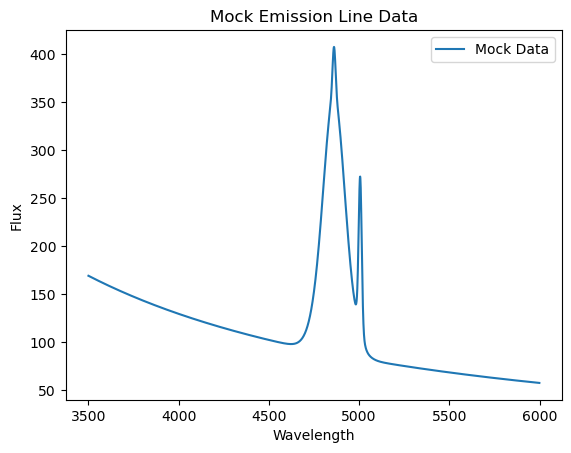

In [3]:
# Create a spectral axis (wavelength range)
wave = np.arange(3500., 6000., 1)  # Example range


# Instantiate the MockSpectrum
mock_spectrum = MockSpectrum(wave)

# Instantiate EmissionComponent
emission_component = EmissionComponent()

EL_PARAMS = {'narrow_width': 500,
             'Hbeta_4861_amp_0': 50,
             'Hbeta_4861_loc_0': 4861,
             'Hbeta_4861_amp_1': 80,
             'Hbeta_4861_loc_1': 4861,
             'Hbeta_4861_width_1': 3000,
             'Hbeta_4861_amp_2': 120,
             'Hbeta_4861_loc_2': 4861,
             'Hbeta_4861_width_2': 4000,
             'Hbeta_4861_amp_3': 70,
             'Hbeta_4861_loc_3': 4861,
             'Hbeta_4861_width_3': 5000,
             '[OIII]_5006_amp_0': 150,
             '[OIII]_5006_loc_0': 5006,
             '[OIII]_5006_amp_1': 15,
             '[OIII]_5006_loc_1': 5005,
             '[OIII]_5006_width_1': 1000}

# Generate initial parameters for the emission lines
initial_params = emission_component.initial_values(mock_spectrum, EL_PARAMS)

# Convert initial_params to a dictionary for the flux method
# Assuming initial_values returns a list in the correct order
param_names = emission_component.model_parameter_names
params_dict = {name: value for name, value in zip(param_names, initial_params)}

# Generate mock flux
el_flux = emission_component.flux(mock_spectrum, params_dict)

pl_flux = powerlaw(wave/4800, 90, 2.0)

flux = el_flux + pl_flux
noise = flux*0.05

plt.plot(wave, flux, label='Mock Data')
plt.legend()
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Mock Emission Line Data')
plt.show()

In [4]:
comp_params = {'EL': EL_PARAMS}

spamm(complist=['EL', 'PL'], inspectrum=(wave, flux, noise), 
      n_walkers=50, n_iterations=2000, parallel=True,
      outdir="newtest_example", picklefile="newtest")

100%|██████████████████████████████████████| 2000/2000 [00:19<00:00, 100.20it/s]


[SPAMM]: Mean acceptance fraction: 0.236
[SPAMM]: Saved pickle file: newtest_example/newtest.pickle.gz
[SPAMM]: Execution time: 21.762 seconds


{'model': <spamm.Model.Model at 0x153018f90>,
 'comp_params': {'wl': array([3500., 3501., 3502., ..., 5997., 5998., 5999.]),
  'flux': array([169.27346939, 169.17678313, 169.08017969, ...,  57.65764323,
          57.63841921,  57.6192048 ]),
  'err': array([8.46367347, 8.45883916, 8.45400898, ..., 2.88288216, 2.88192096,
         2.88096024]),
  'components': {'PL': True,
   'FE': False,
   'HG': False,
   'BC': False,
   'BPC': False,
   'NEL': False,
   'EL': True,
   'CALZETTI_EXT': False,
   'SMC_EXT': False,
   'MW_EXT': False,
   'AGN_EXT': False,
   'LMC_EXT': False}}}

In [6]:
S = Samples("newtest_example/newtest.pickle.gz", outdir='newtest_example', burn=600)
plot_best_models(S)

[SPAMM]: Saved newtest_bestfits.png


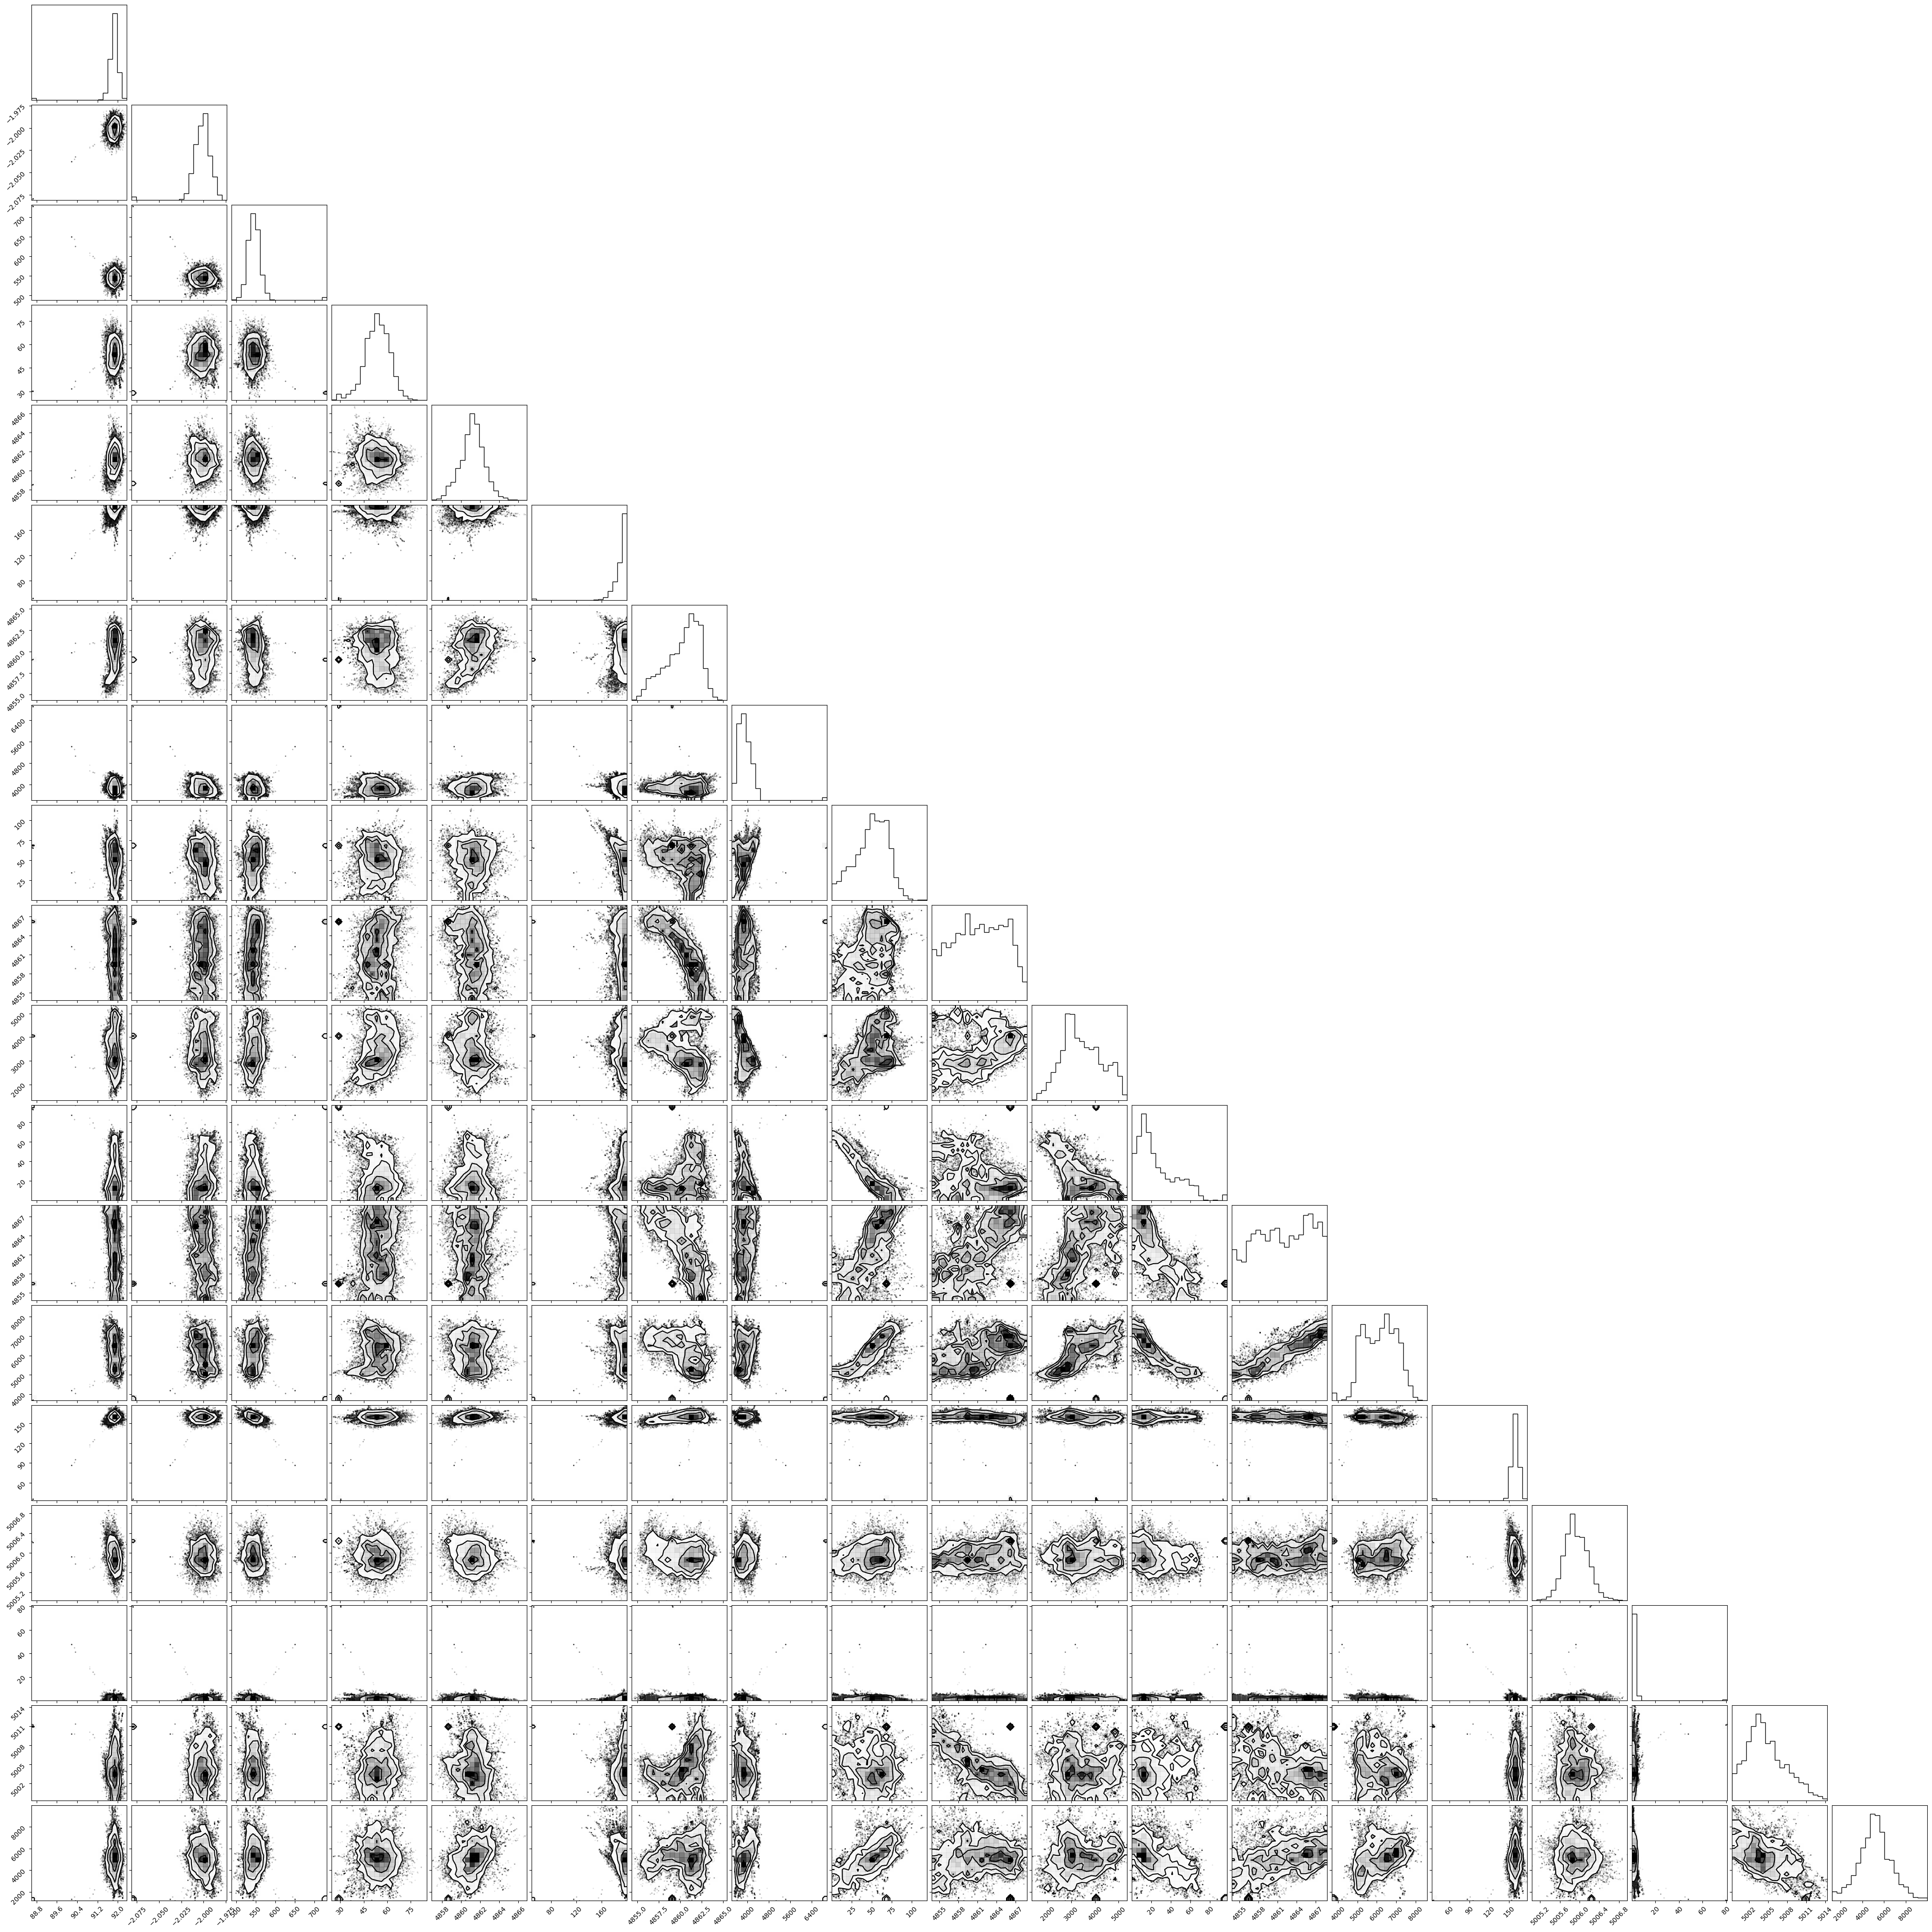

In [7]:
flat_samples = S.model.sampler.get_chain(discard=600, thin=2, flat=True)
fig = corner.corner(flat_samples);